Random C-index: 0.5304


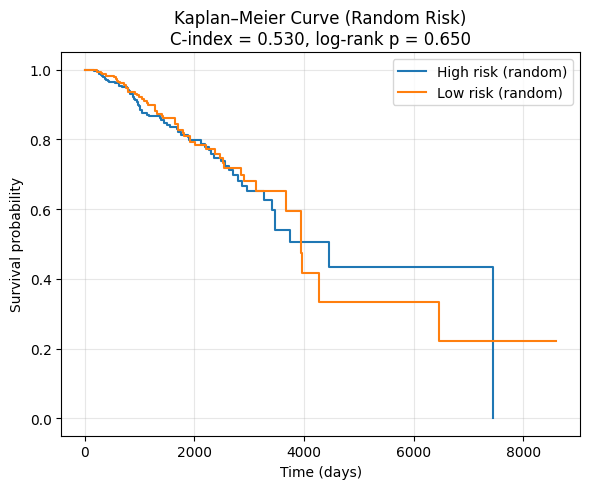

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# =========================
# Load data
# =========================
df = pd.read_csv("TRGAted-master/BRCA.csv")

T = df["OS.time"]
E = df["OS"]

# =========================
# Random risk score
# =========================
np.random.seed(42)
random_risk = np.random.rand(len(df))

# C-index (higher risk -> shorter survival)
c_index = concordance_index(T, -random_risk, E)
print(f"Random C-index: {c_index:.4f}")

# =========================
# Median split: high / low risk
# =========================
median_risk = np.median(random_risk)
high_risk_mask = random_risk >= median_risk
low_risk_mask = random_risk < median_risk

# =========================
# Kaplan–Meier fitting
# =========================
kmf_high = KaplanMeierFitter()
kmf_low = KaplanMeierFitter()

plt.figure(figsize=(6, 5))

kmf_high.fit(
    T[high_risk_mask],
    event_observed=E[high_risk_mask],
    label="High risk (random)"
)
kmf_high.plot(ci_show=False)

kmf_low.fit(
    T[low_risk_mask],
    event_observed=E[low_risk_mask],
    label="Low risk (random)"
)
kmf_low.plot(ci_show=False)

# =========================
# Log-rank test
# =========================
results = logrank_test(
    T[high_risk_mask], T[low_risk_mask],
    event_observed_A=E[high_risk_mask],
    event_observed_B=E[low_risk_mask]
)

# =========================
# Plot settings
# =========================
plt.title(
    f"Kaplan–Meier Curve (Random Risk)\n"
    f"C-index = {c_index:.3f}, log-rank p = {results.p_value:.3f}"
)
plt.xlabel("Time (days)")
plt.ylabel("Survival probability")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# =========================
# Load data
# =========================
df = pd.read_csv("TRGAted-master/BRCA.csv")

T = df["OS.time"]
E = df["OS"]

# =========================
# Remove outcome-derived variables
# =========================
outcome_vars = [
    "OS", "OS.time",
    "DSS", "DSS.time",
    "DFI", "DFI.time",
    "PFI", "PFI.time"
]

X = df.select_dtypes(include=[np.number]).drop(columns=outcome_vars)

# Drop unstable columns
X = X.dropna(axis=1, thresh=len(X) * 0.7)
X = X.fillna(X.median())


In [6]:
pearson_results = []

for col in X.columns:
    r, p = pearsonr(X[col], T)
    pearson_results.append({
        "feature": col,
        "pearson_r": r,
        "abs_r": abs(r),
        "p_value": p
    })

pearson_df = pd.DataFrame(pearson_results)\
               .sort_values("abs_r", ascending=False)

print(pearson_df.head(20))

# 可选：保存
pearson_df.to_csv("pearson_OS_time_no_outcome.csv", index=False)


                  feature  pearson_r     abs_r       p_value
215        TUBERIN_pT1462  -0.190233  0.190233  1.474616e-08
84                  EIF4G  -0.171228  0.171228  3.588414e-07
140         NFKBP65_pS536  -0.160612  0.160612  1.844642e-06
214               TUBERIN  -0.159563  0.159563  2.156528e-06
66             COLLAGENVI   0.159512  0.159512  2.173061e-06
152          P70S6K_pT389   0.141887  0.141887  2.581419e-05
123                   LCK   0.139970  0.139970  3.322575e-05
158              PAXILLIN  -0.139943  0.139943  3.334154e-05
106  GSK3ALPHABETA_pS21S9  -0.137615  0.137615  4.510059e-05
148         P38_pT180Y182   0.133134  0.133134  7.960398e-05
184          RB_pS807S811  -0.130926  0.130926  1.046369e-04
205           STAT3_pY705   0.121918  0.121918  3.055101e-04
104              GSK3_pS9  -0.118959  0.118959  4.277948e-04
44    CASPASE7CLEAVEDD198   0.116340  0.116340  5.727040e-04
38                   BRAF  -0.114445  0.114445  7.046621e-04
65                   COG

In [7]:
# =========================
# Standardize
# =========================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =========================
# Regression on OS.time
# =========================
reg = LinearRegression()
reg.fit(X_scaled, T)

pred_time = reg.predict(X_scaled)

# 连续回归性能（仅作 sanity）
r_reg, _ = pearsonr(pred_time, T)
print(f"Prediction vs OS.time Pearson r: {r_reg:.3f}")


Prediction vs OS.time Pearson r: 0.592


C-index (binary risk model): 0.3204


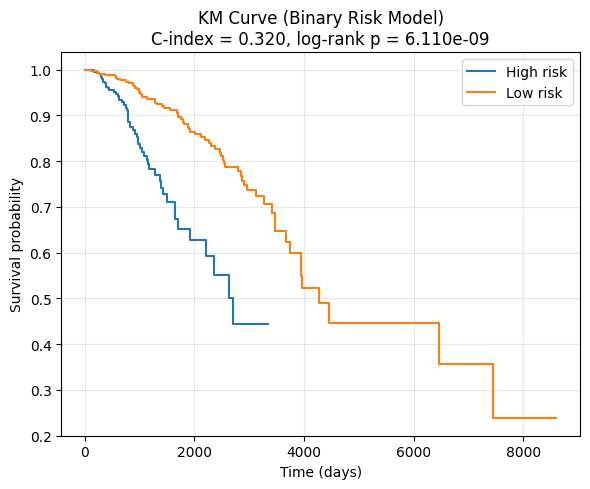

In [8]:
# =========================
# Risk score
# shorter predicted survival = higher risk
# =========================
risk_score = -pred_time

# =========================
# C-index
# =========================
c_index = concordance_index(T, risk_score, E)
print(f"C-index (binary risk model): {c_index:.4f}")

# =========================
# Median split
# =========================
median_risk = np.median(risk_score)
high_risk = risk_score >= median_risk
low_risk = risk_score < median_risk

# =========================
# Kaplan–Meier
# =========================
kmf_high = KaplanMeierFitter()
kmf_low = KaplanMeierFitter()

plt.figure(figsize=(6, 5))

kmf_high.fit(T[high_risk], event_observed=E[high_risk], label="High risk")
kmf_high.plot(ci_show=False)

kmf_low.fit(T[low_risk], event_observed=E[low_risk], label="Low risk")
kmf_low.plot(ci_show=False)

# =========================
# Log-rank test
# =========================
lr = logrank_test(
    T[high_risk], T[low_risk],
    event_observed_A=E[high_risk],
    event_observed_B=E[low_risk]
)

plt.title(
    f"KM Curve (Binary Risk Model)\n"
    f"C-index = {c_index:.3f}, log-rank p = {lr.p_value:.3e}"
)
plt.xlabel("Time (days)")
plt.ylabel("Survival probability")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
